In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
from tqdm import tqdm

## Load and split the dataset 

In [2]:
data = pd.read_csv('Alignment-1-Learning.csv')

In [3]:
data.head()

,mH1,mH2,mH3,mA1,mA2,mC1,mC2,TanBeta1,TanBeta2,TanAlpha4,TanGamma1,TanGamma2,TanAlpha1,TanAlpha2,Output
0,125.0,389.681890,266.205554,357.716926,216.548541,437.974724,291.549211,1.825617,0.708838,5.560399,21.627008,24.836633,1.825617,0.708838,1
1,125.0,466.478864,389.569317,402.965051,380.172764,364.184617,381.934382,1.054113,0.609084,10.036226,20.546985,15.891286,1.054113,0.609084,1
2,125.0,220.948750,486.689377,537.099375,320.173513,243.467599,406.498383,1.303290,0.919230,13.261847,23.903331,21.670848,1.303290,0.919230,1
3,125.0,328.343580,323.472676,221.752325,348.389320,487.707855,305.971767,0.793804,0.669176,11.678012,12.508026,14.745824,0.793804,0.669176,1
4,125.0,335.247929,211.280269,206.867278,340.005918,207.546645,227.085078,2.043520,1.108583,16.270581,13.387200,20.521982,2.043520,1.108583,1


In [4]:
#check for any empty cell in database
data.isna().sum()

mH1          0
mH2          0
mH3          0
mA1          0
mA2          0
mC1          0
mC2          0
TanBeta1     0
TanBeta2     0
TanAlpha4    0
TanGamma1    0
TanGamma2    0
TanAlpha1    0
TanAlpha2    0
Output       0
dtype: int64

In [5]:
#shuffle the dataframe

data_sh = data.sample(frac = 1.0, random_state = 42)

#reset the index

data_sh = data_sh.reset_index(drop=True)

In [6]:
#put feature variable to X and target variable to Y

X = data_sh.drop('Output', axis = 1)
Y = data_sh['Output']

In [7]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state = 42)

#Split the training data further into labeled and unlabeled dataset

X_labeled, X_unlabeled, Y_labeled, Y_unlabeled = train_test_split(X_train, Y_train, test_size = 0.9998, random_state = 42)

In [8]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of labeled datapoints: {len(X_labeled)}")
print(f"Number of unlabeled datapoints: {len(X_unlabeled)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 39495
Number of labeled datapoints: 4
Number of unlabeled datapoints: 23693
Number of test datapoints: 15798


## Objective 1 - Create a TSNE Plot using the entire dataset 

In [10]:
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [11]:
# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_results = tsne.fit_transform(features)

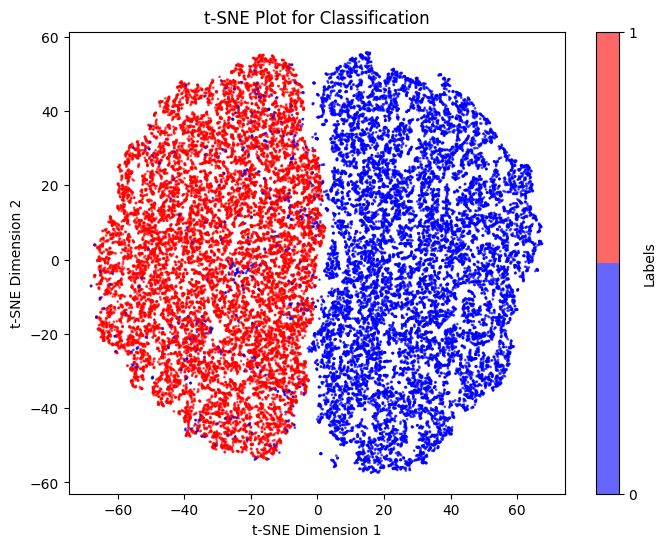

In [16]:
custom_cmap = ListedColormap(['blue', 'red'])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=custom_cmap, marker='o', s=1, alpha=0.6)

# Add a colorbar for label mapping
plt.colorbar(scatter, label='Labels', ticks=np.unique(labels))

plt.title('t-SNE Plot for Classification')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Objective 2 - Plot the active learning accuracy 

In [9]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 200, random_state = 42)

In [10]:
#active learning loop
num_iterations = 42

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_labeled, Y_labeled)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(X_unlabeled),axis = 1)
    
    #Select the most uncertain samples
    num_samples_to_label = 550
    selected_indices = np.argsort(uncertainty_scores)[-num_samples_to_label:]
    
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
    
    
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
final_random_forest.fit(X_labeled, Y_labeled)

#Move all remaining samples from unlabeled to test data 
if len(X_unlabeled) != 0:
    #move the selected samples from unlabeled to test data
    X_test = pd.concat([X_test, X_unlabeled])
    Y_test = pd.concat([Y_test, pd.Series(Y_unlabeled)])
    
    #Empty the unlabeled dataset
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index)
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")

Iteration : 1: Test Accuracy = 0.896569
Iteration : 2: Test Accuracy = 0.916319
Iteration : 3: Test Accuracy = 0.926193
Iteration : 4: Test Accuracy = 0.937587
Iteration : 5: Test Accuracy = 0.947715
Iteration : 6: Test Accuracy = 0.950943
Iteration : 7: Test Accuracy = 0.951513
Iteration : 8: Test Accuracy = 0.964932
Iteration : 9: Test Accuracy = 0.967717
Iteration : 10: Test Accuracy = 0.969110
Iteration : 11: Test Accuracy = 0.969743
Iteration : 12: Test Accuracy = 0.990379
Iteration : 13: Test Accuracy = 0.989239
Iteration : 14: Test Accuracy = 0.989049
Iteration : 15: Test Accuracy = 0.996708
Iteration : 16: Test Accuracy = 0.997341
Iteration : 17: Test Accuracy = 0.997721
Iteration : 18: Test Accuracy = 0.997595
Iteration : 19: Test Accuracy = 0.997658
Iteration : 20: Test Accuracy = 0.997531
Iteration : 21: Test Accuracy = 0.997785
Iteration : 22: Test Accuracy = 0.997595
Iteration : 23: Test Accuracy = 0.997658
Iteration : 24: Test Accuracy = 0.997785
Iteration : 25: Test Accu

Text(0, 0.5, 'Accuracy')

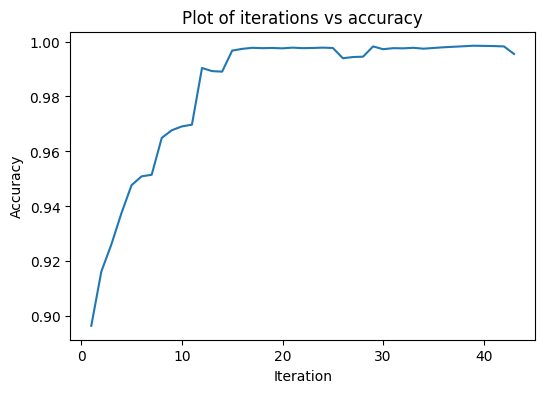

In [11]:
# Plot iteration vs accuracy

plt.figure(figsize=(6, 4))
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

## Objective 3 - Visualize Classfication Boundary 

In [9]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [10]:
#Function that predicts classification boundary

def TSNE_boundary(X_labeled,Y_labeled):
    #Create a TSNE Boundary Prediction Plot
    features = X_labeled.values
    labels = Y_labeled.values
    
    tsne = TSNE(n_components=2, perplexity=2, learning_rate=100)
    tsne_results = tsne.fit_transform(features)
    
    #Code to train the Decision Tree Classifier in the TSNE space
    random_tsne = RandomForestClassifier(n_estimators = 100, random_state = 42)
    random_tsne.fit(tsne_results, labels)
    
    # Create a grid of points in the t-SNE space
    x_min, x_max = tsne_results[:, 0].min() - 1, tsne_results[:, 0].max() + 1
    y_min, y_max = tsne_results[:, 1].min() - 1, tsne_results[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
    
    # Use the Random Forest Classifier to predict labels for the grid points
    Z = random_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the t-SNE scatter points
    plt.figure(figsize=(8, 6))
    custom_cmap = ListedColormap(['blue', 'red'])
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=custom_cmap, marker='o', s=1, alpha=1)

    # Overlay a decision boundary as a line
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)

    # Add a colorbar for label mapping
    plt.colorbar(scatter, label='Labels', ticks=np.unique(labels))

    plt.title('t-SNE Plot with Decision Boundaries')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

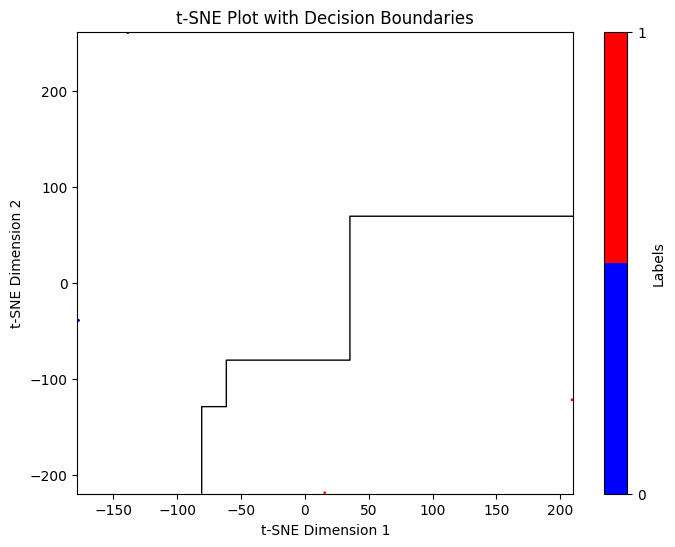

Iteration : 1: Test Accuracy = 0.919990


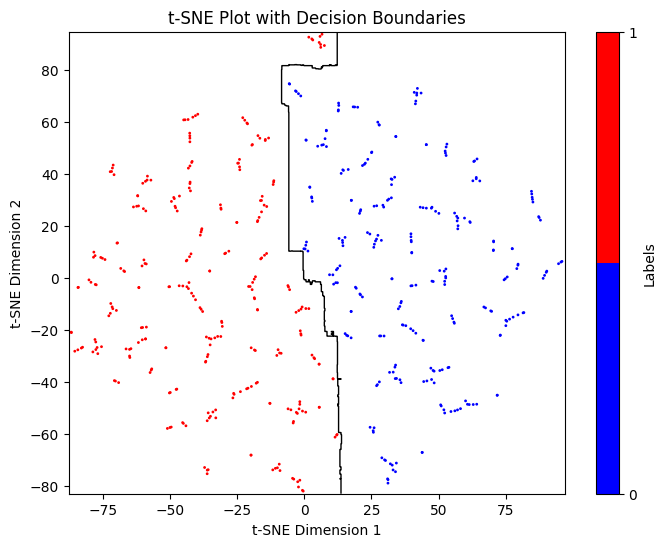

Iteration : 2: Test Accuracy = 0.939992


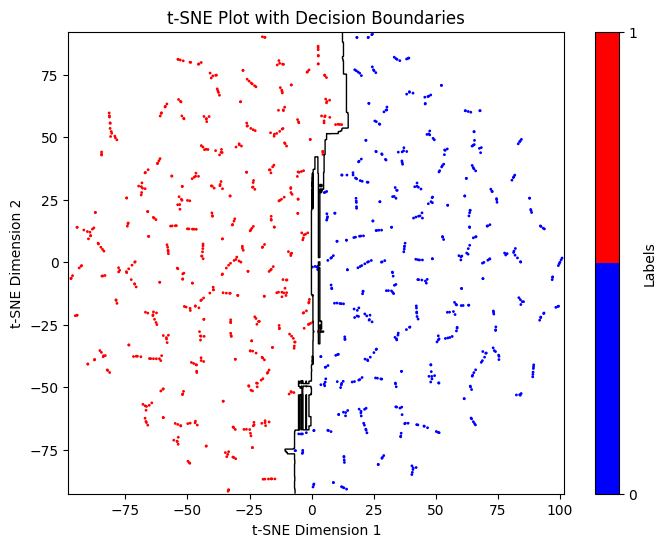

Iteration : 3: Test Accuracy = 0.953982


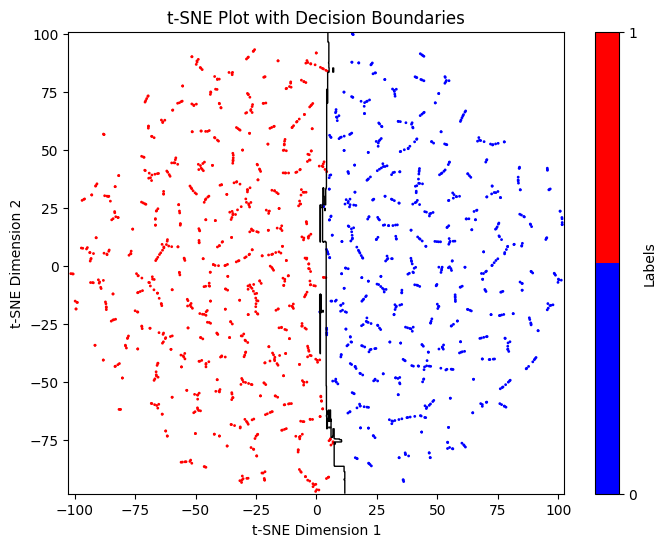

Iteration : 4: Test Accuracy = 0.963666


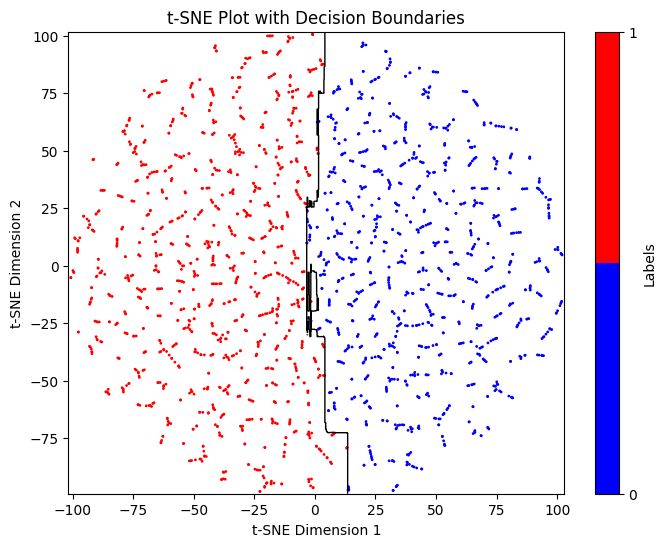

Iteration : 5: Test Accuracy = 0.966451


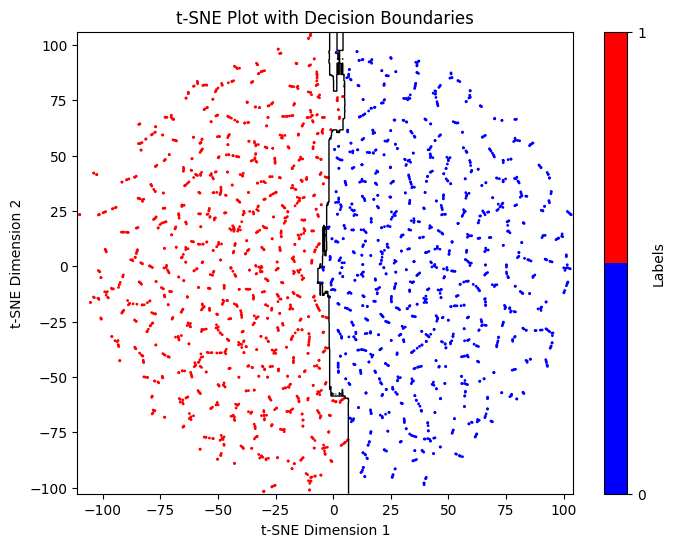

Iteration : 6: Test Accuracy = 0.967717


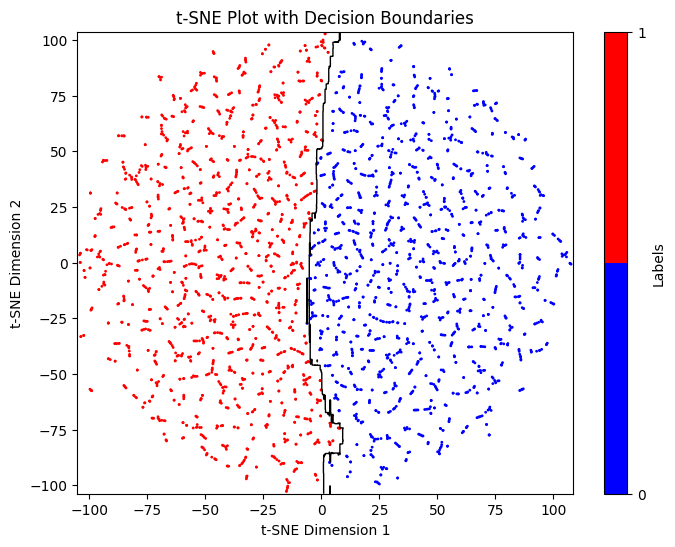

Iteration : 7: Test Accuracy = 0.968857


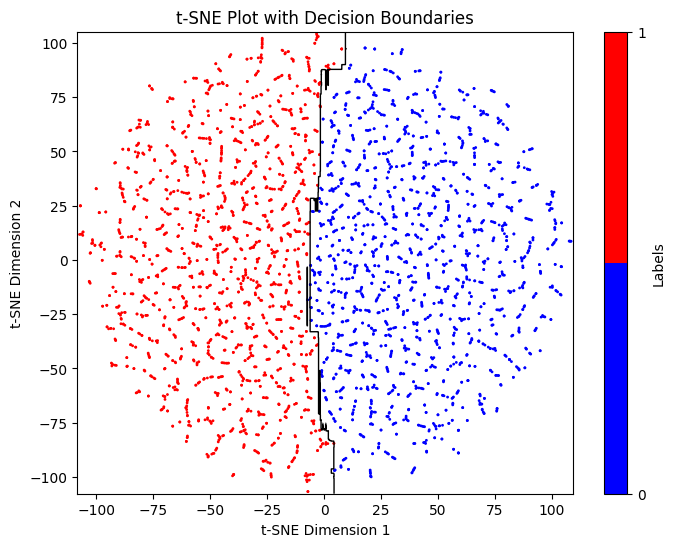

Iteration : 8: Test Accuracy = 0.970060


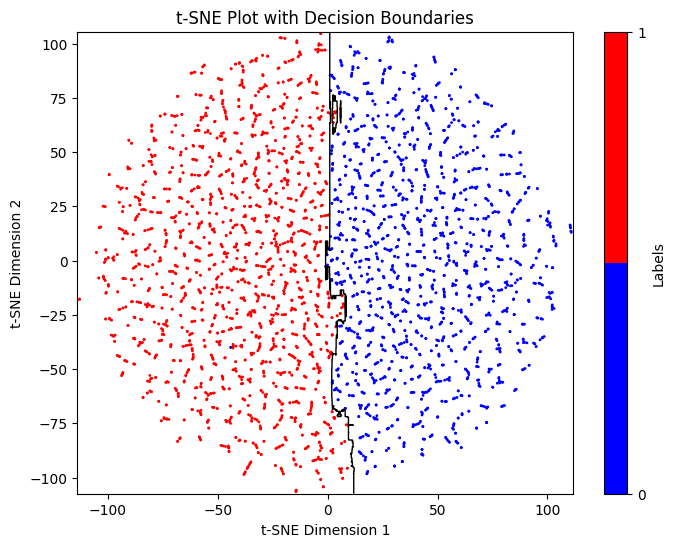

Iteration : 9: Test Accuracy = 0.976706


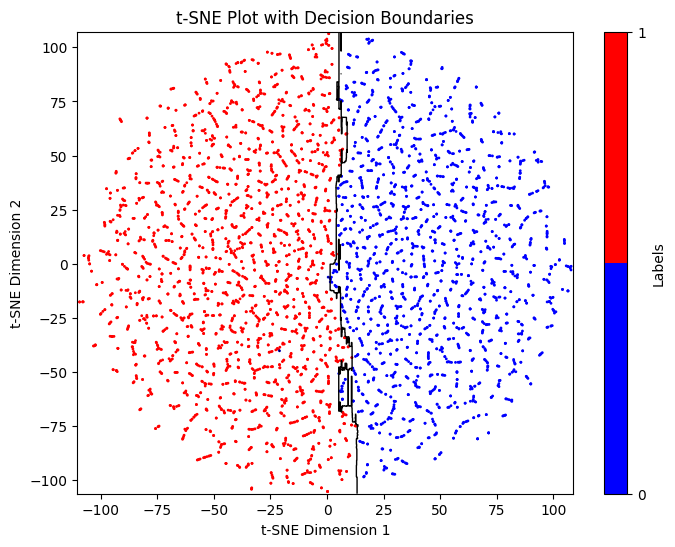

Iteration : 10: Test Accuracy = 0.976769


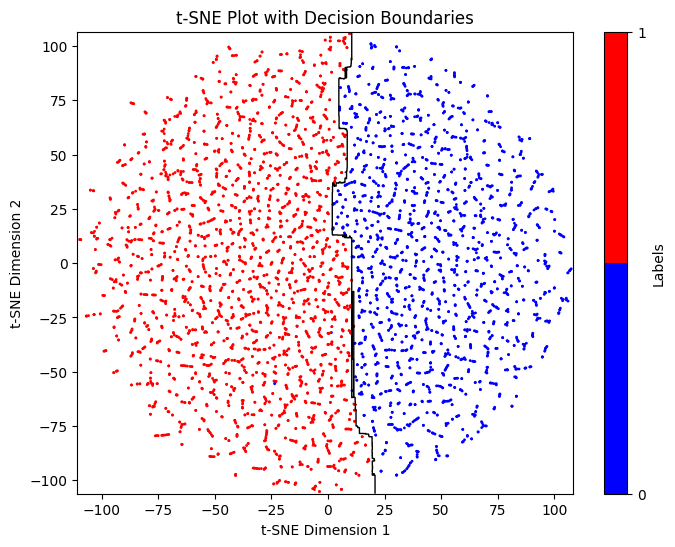

Iteration : 11: Test Accuracy = 0.976706


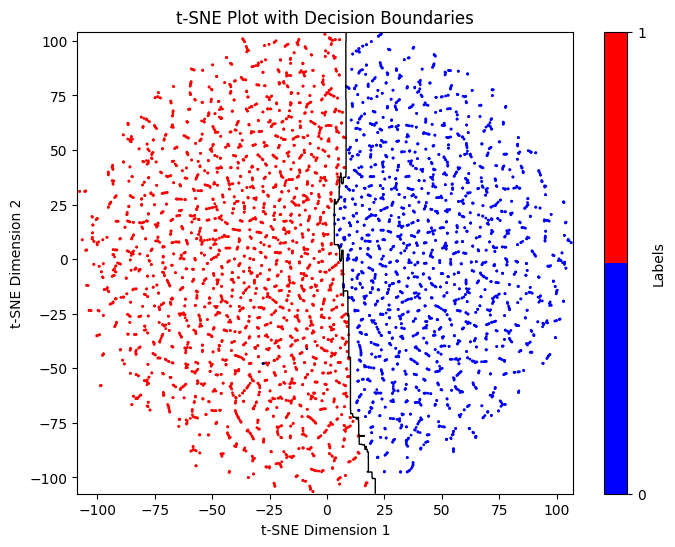

Iteration : 12: Test Accuracy = 0.992341


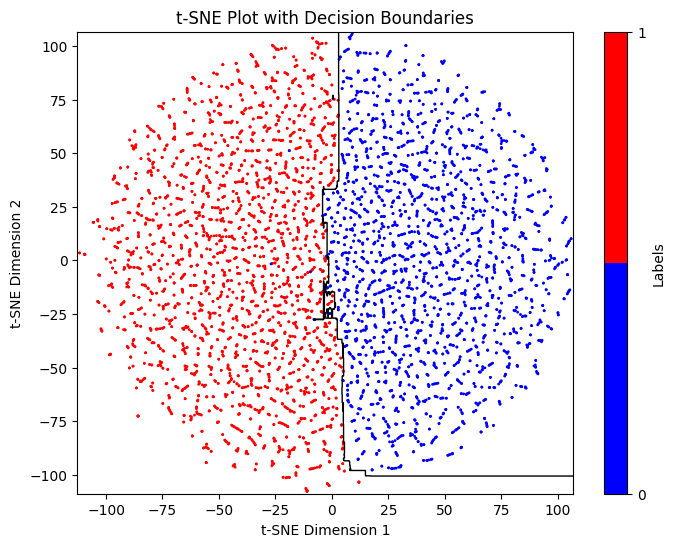

Iteration : 13: Test Accuracy = 0.992784


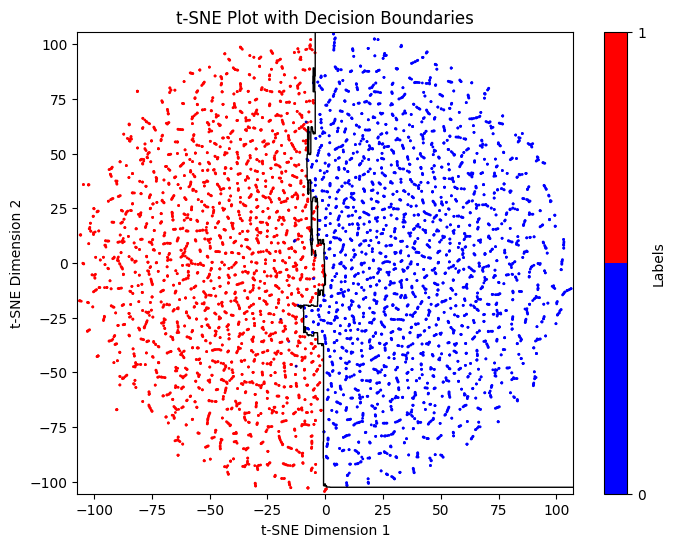

Iteration : 14: Test Accuracy = 0.992404


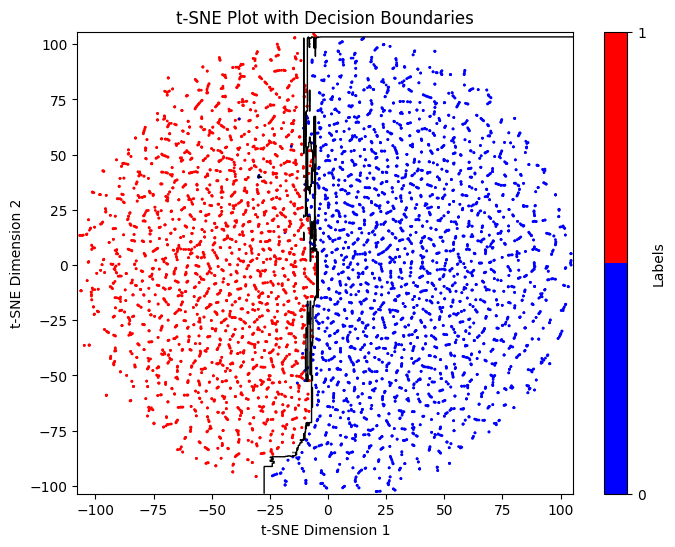

Iteration : 15: Test Accuracy = 0.992151


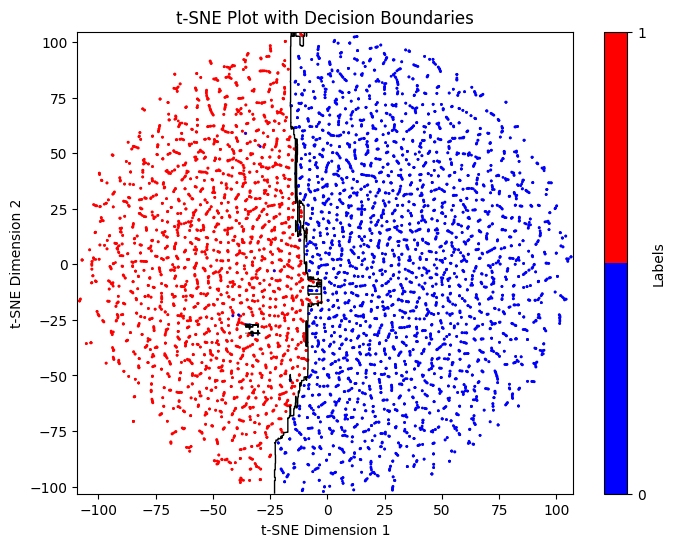

Iteration : 16: Test Accuracy = 0.991771


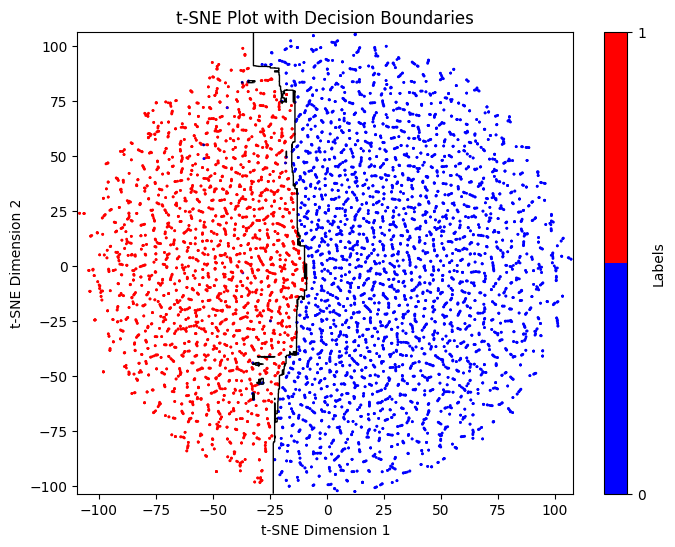

Iteration : 17: Test Accuracy = 0.990568


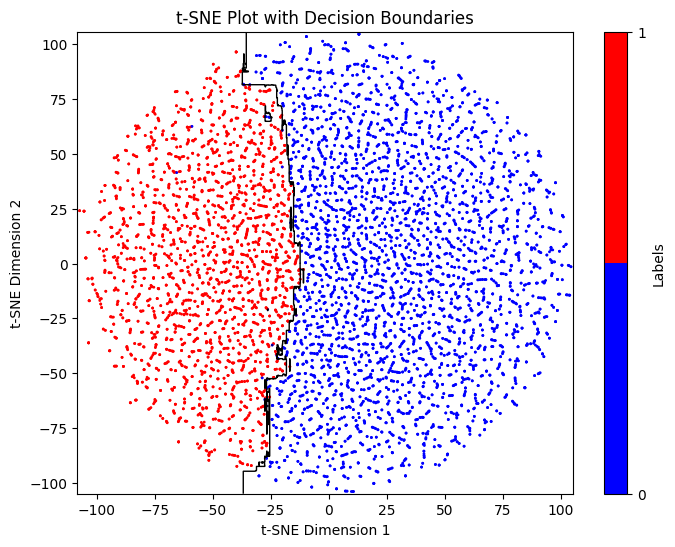

Iteration : 18: Test Accuracy = 0.990568


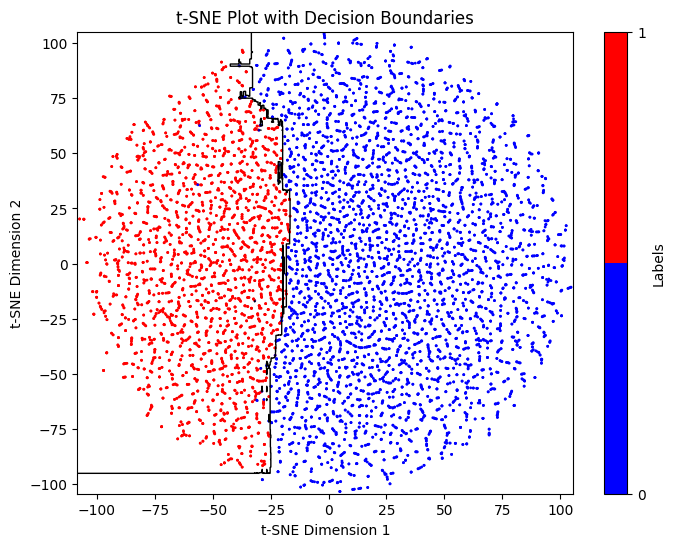

Iteration : 19: Test Accuracy = 0.990505


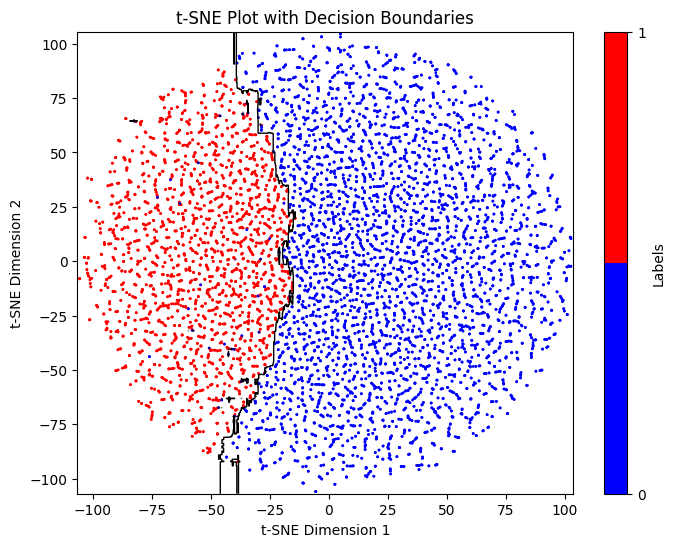

Iteration : 20: Test Accuracy = 0.993860


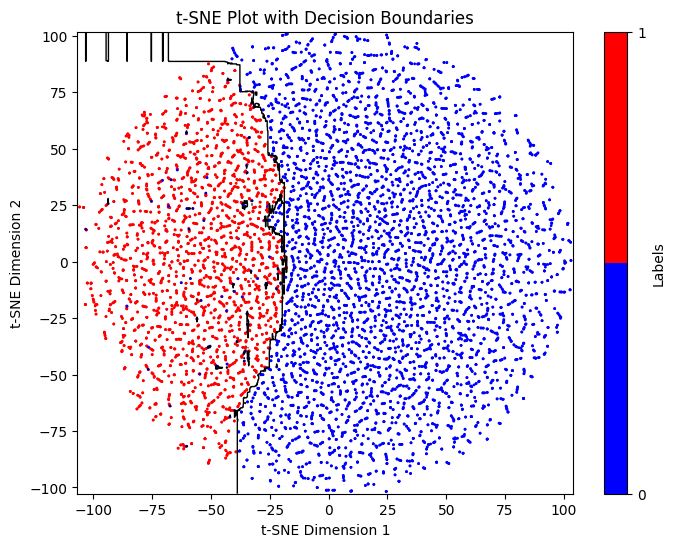

Final Model Test Accuracy: 0.989786


In [11]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    
    #Call the TSNE Boundary function which predicts classification boundary
    TSNE_boundary(X_labeled,Y_labeled)
    
    #Train the model
    random_forest.fit(X_labeled, Y_labeled)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(X_unlabeled),axis = 1)
    
    #Select the most uncertain samples
    num_samples_to_label = 550
    selected_indices = np.argsort(uncertainty_scores)[-num_samples_to_label:]
    
    #move the selected samples from unlabeled to labeled data
    X_labeled = pd.concat([X_labeled, X_unlabeled.iloc[selected_indices]])
    Y_labeled = pd.concat([Y_labeled, pd.Series(Y_unlabeled.iloc[selected_indices])])
    
    #Remove the newly labeled samples from the unlabeled data
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[selected_indices])
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index[selected_indices])
        
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
final_random_forest.fit(X_labeled, Y_labeled)

#Move all remaining samples from unlabeled to test data 
if len(X_unlabeled) != 0:
    #move the selected samples from unlabeled to test data
    X_test = pd.concat([X_test, X_unlabeled])
    Y_test = pd.concat([Y_test, pd.Series(Y_unlabeled)])
    
    #Empty the unlabeled dataset
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index)
    Y_unlabeled = Y_unlabeled.drop(Y_unlabeled.index)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy

TSNE_boundary(X_labeled,Y_labeled)

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")

Text(0, 0.5, 'Accuracy')

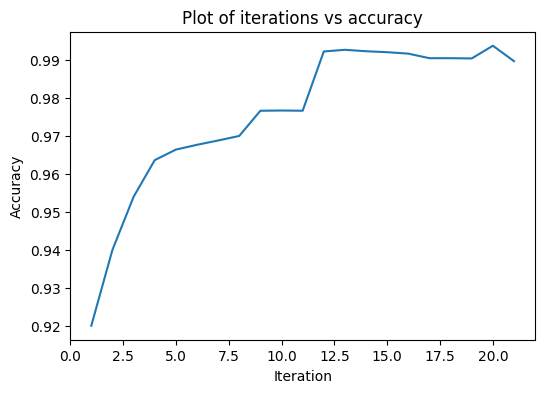

In [12]:
# Plot iteration vs accuracy

plt.figure(figsize=(6, 4))
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

## Objective 4 - Generate new points and label them within the active learning loop

In [23]:
#Split into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.873, random_state = 42)

In [24]:
print(f"Total Number of datapoints: {len(X)}")
print(f"Number of train datapoints: {len(X_train)}")
print(f"Number of test datapoints: {len(X_test)}")

Total Number of datapoints: 39495
Number of train datapoints: 5015
Number of test datapoints: 34480


In [25]:
#Initialize the Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators = 200, random_state = 42)

In [26]:
#defining a function that generates and labels live most uncertain datapoints

import Functions as func

def live_generation(gen_batch_size,seed,unc_batch_size):
    
    #generate new datapoints :- syntax (generate(batch,seed))
    points = func.generate(gen_batch_size,seed)
    
    #Calculate uncertainty scores
    uncertainty_scores = np.max(random_forest.predict_proba(points),axis = 1)
    
    #Select the indices of the most uncertain samples
    num_samples_to_label = unc_batch_size
    selected_indices = np.argsort(uncertainty_scores)[-num_samples_to_label:]
    
    #convert the pandas dataframe to array/list
    points_array = points.values
    
    #create a numpy array of the selected most uncertain samples from the indices
    data_tolabel = np.array([points_array[i] for i in selected_indices])
    
    #check the constraints on the the generated dataset
    points_allowed, points_disallowed = func.constraints_check(data_tolabel)
    
    #create a pandas dataframe of the check dataset
    column_names = ['mH1','mH2','mH3','mA1','mA2','mC1','mC2','TanBeta1','TanBeta2','TanAlpha4','TanGamma1','TanGamma2','TanAlpha1','TanAlpha2']

    data_disallowed = pd.DataFrame(points_disallowed, columns=column_names)
    data_allowed = pd.DataFrame(points_allowed, columns=column_names)
    
    #label the dataset
    data_allowed['Output'] = 1
    data_disallowed['Output'] = 0
    
    #merge the dataset
    labeled = pd.concat([data_allowed,data_disallowed], ignore_index=True)
    
    #extract the X_labeled and Y_labeled
    X_labeled = labeled.drop('Output', axis = 1)
    Y_labeled = labeled['Output']
    
    return X_labeled, Y_labeled

In [ ]:
#active learning loop
num_iterations = 20

num_it_array = np.arange(1,num_iterations+2,1)
accuracy_array = np.zeros(num_iterations+1)

for iteration in range(num_iterations):
    #Train the model
    random_forest.fit(X_train, Y_train)
    
    #predict on the test data
    Y_test_pred = random_forest.predict(X_test)
    
    #Calculate accuracy on the test set
    accuracy = accuracy_score(Y_test,Y_test_pred)
    accuracy_array[iteration] = accuracy
    print(f"Iteration : {iteration + 1}: Test Accuracy = {accuracy:.6f}")
    
    #generate and label new data points :- syntax (live_generation(gen_batch_size,seed,unc_batch_size))
    seed = 5000
    X_new, Y_new = live_generation(30000000,seed,2000)
   
    #move the selected samples from unlabeled to labeled data
    X_train = pd.concat([X_train, X_new])
    Y_train = pd.concat([Y_train, pd.Series(Y_new)])
    
    #increase the count of seed
    seed = seed + 1
       
#Train the final model on all labeled data 
final_random_forest = RandomForestClassifier(n_estimators = 200, random_state = 42)
final_random_forest.fit(X_train, Y_train)

#Evaluate the final model on the test data
Y_test_pred = final_random_forest.predict(X_test)
final_accuracy = accuracy_score(Y_test, Y_test_pred)
accuracy_array[-1] = final_accuracy

print(f"Final Model Test Accuracy: {final_accuracy:.6f}")

Iteration : 1: Test Accuracy = 0.999333
Iteration : 2: Test Accuracy = 0.999420
Iteration : 3: Test Accuracy = 0.999275
Iteration : 4: Test Accuracy = 0.999333
Iteration : 5: Test Accuracy = 0.999246
Iteration : 6: Test Accuracy = 0.999246
Iteration : 7: Test Accuracy = 0.999275
Iteration : 8: Test Accuracy = 0.999246
Iteration : 9: Test Accuracy = 0.999304
Iteration : 10: Test Accuracy = 0.999217
Iteration : 11: Test Accuracy = 0.999304
Iteration : 12: Test Accuracy = 0.999304
Iteration : 13: Test Accuracy = 0.999304
Iteration : 14: Test Accuracy = 0.999275


## Accuracy Plots for different configurations

Text(0, 0.5, 'Accuracy')

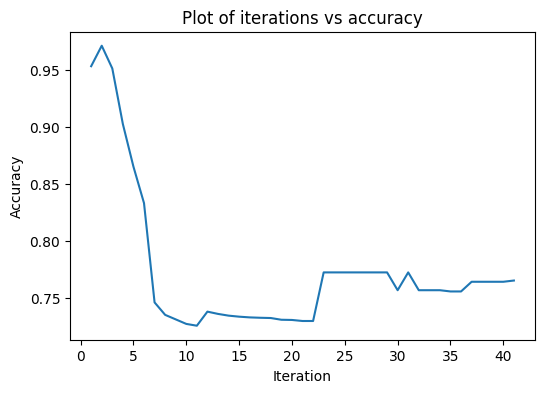

In [12]:
# Plot iteration vs accuracy

#Configuration (n_estimators = 100, num_iterations = 40, train_init = 7, live_generation(20000000,1000,1500))

plt.figure(figsize=(6, 4))
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

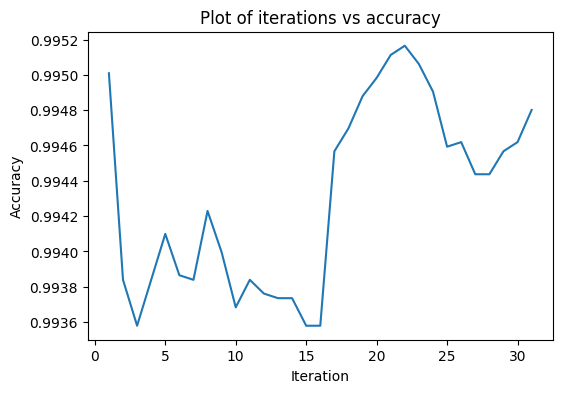

In [24]:
# Plot iteration vs accuracy

#Configuration (n_estimators = 200, num_iterations = 30, train_init = 5015, live_generation(30000000,5000,2000))

plt.figure(figsize=(6, 4))
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

In [ ]:
# Plot iteration vs accuracy

#Configuration (n_estimators = 200, num_iterations = 20, train_init = 1026, live_generation(30000000,4000,2000))

plt.figure(figsize=(6, 4))
plt.plot(num_it_array, accuracy_array)
plt.title("Plot of iterations vs accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")